**Install and import dependencies**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

**Read in data and process dates**

In [2]:
#loading data
train_df = pd.read_csv('/Users/hailing/Downloads/store-sales-time-series-forecasting/train.csv')
oil_df = pd.read_csv('/Users/hailing/Downloads/store-sales-time-series-forecasting/oil.csv')

In [3]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
train_df.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [5]:
train_df.shape

(3000888, 6)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [7]:
#Split the date into year, month, date
train_df['Year'] = train_df['date'].apply(lambda x: str(x)[:4])
train_df['Month'] = train_df['date'].apply(lambda x: str(x)[5:7])
train_df['Day'] = train_df['date'].apply(lambda x: str(x)[8:10])

In [8]:
train_df['ds'] = pd.to_datetime(train_df['Year'].astype(str) + '-' + train_df['Month'].astype(str) + '-' + train_df['Day'].astype(str))

In [9]:
train_df.tail()

,id,date,store_nbr,family,sales,onpromotion,Year,Month,Day,ds
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2017,08,15,2017-08-15
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,08,15,2017-08-15
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,08,15,2017-08-15
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,08,15,2017-08-15
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,2017,08,15,2017-08-15


In [10]:
train_df.dtypes

id                      int64
date                   object
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
Year                   object
Month                  object
Day                    object
ds             datetime64[ns]
dtype: object

In [11]:
#drop columns unrelated to our time series forcasting modelling (we only need the ds and sales column)
train_df.drop(['id','date','onpromotion','store_nbr','family','Year','Month','Day'],axis=1, inplace=True)

#renaming the columns to y(for sales) and ds
train_df.columns=['y','ds']
train_df.head()

,y,ds
0,0.0,2013-01-01
1,0.0,2013-01-01
2,0.0,2013-01-01
3,0.0,2013-01-01
4,0.0,2013-01-01


**Train model**

In [12]:
m=Prophet(interval_width=0.95,daily_seasonality=True)
model=m.fit(train_df)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


**Forecast- train df(sales)**

In [13]:
# Making predictions for 2 years (since we're using D as our frequency, we'll multiply 365 days by 2 years)
future = model.make_future_dataframe(periods=365*2, freq='D')

In [14]:
# Forecasting
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,33.541265,-1963.002713,2311.968288,33.541265,33.541265,165.695736,165.695736,165.695736,134.165061,...,-38.232436,-38.232436,-38.232436,69.763111,69.763111,69.763111,0.0,0.0,0.0,199.237001
1,2013-01-02,34.224776,-1985.469365,2292.534547,34.224776,34.224776,172.696122,172.696122,172.696122,134.165061,...,-24.743803,-24.743803,-24.743803,63.274864,63.274864,63.274864,0.0,0.0,0.0,206.920898
2,2013-01-03,34.908286,-2142.219924,2254.324825,34.908286,34.908286,116.913486,116.913486,116.913486,134.165061,...,-74.018193,-74.018193,-74.018193,56.766617,56.766617,56.766617,0.0,0.0,0.0,151.821772
3,2013-01-04,35.591797,-1800.869269,2250.910213,35.591797,35.591797,152.440922,152.440922,152.440922,134.165061,...,-32.062099,-32.062099,-32.062099,50.337960,50.337960,50.337960,0.0,0.0,0.0,188.032719
4,2013-01-05,36.275307,-1732.732939,2446.545016,36.275307,36.275307,253.461541,253.461541,253.461541,134.165061,...,75.213547,75.213547,75.213547,44.082934,44.082934,44.082934,0.0,0.0,0.0,289.736849


In [15]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2409,2019-08-11,550.308990,-2276.723172,3635.033627,-1481.616461,2632.164682,191.829011,191.829011,191.829011,134.165061,...,105.704774,105.704774,105.704774,-48.040824,-48.040824,-48.040824,0.0,0.0,0.0,742.138001
2410,2019-08-12,550.542757,-2523.959957,3676.945975,-1485.134789,2635.474463,73.811606,73.811606,73.811606,134.165061,...,-11.861790,-11.861790,-11.861790,-48.491665,-48.491665,-48.491665,0.0,0.0,0.0,624.354363
2411,2019-08-13,550.776524,-2247.890996,3566.669277,-1488.653118,2638.784243,47.360427,47.360427,47.360427,134.165061,...,-38.232436,-38.232436,-38.232436,-48.572197,-48.572197,-48.572197,0.0,0.0,0.0,598.136952
2412,2019-08-14,551.010291,-2401.904331,3814.843068,-1492.171446,2642.094023,61.140857,61.140857,61.140857,134.165061,...,-24.743803,-24.743803,-24.743803,-48.280401,-48.280401,-48.280401,0.0,0.0,0.0,612.151149
2413,2019-08-15,551.244058,-2390.401989,3626.818139,-1495.689774,2645.403804,12.525537,12.525537,12.525537,134.165061,...,-74.018193,-74.018193,-74.018193,-47.621332,-47.621332,-47.621332,0.0,0.0,0.0,563.769595


In [16]:
#extract the date and actual predictions
forecast[['ds','yhat']]

,ds,yhat
0,2013-01-01,199.237001
1,2013-01-02,206.920898
2,2013-01-03,151.821772
3,2013-01-04,188.032719
4,2013-01-05,289.736849
...,...,...
2409,2019-08-11,742.138001
2410,2019-08-12,624.354363
2411,2019-08-13,598.136952
2412,2019-08-14,612.151149


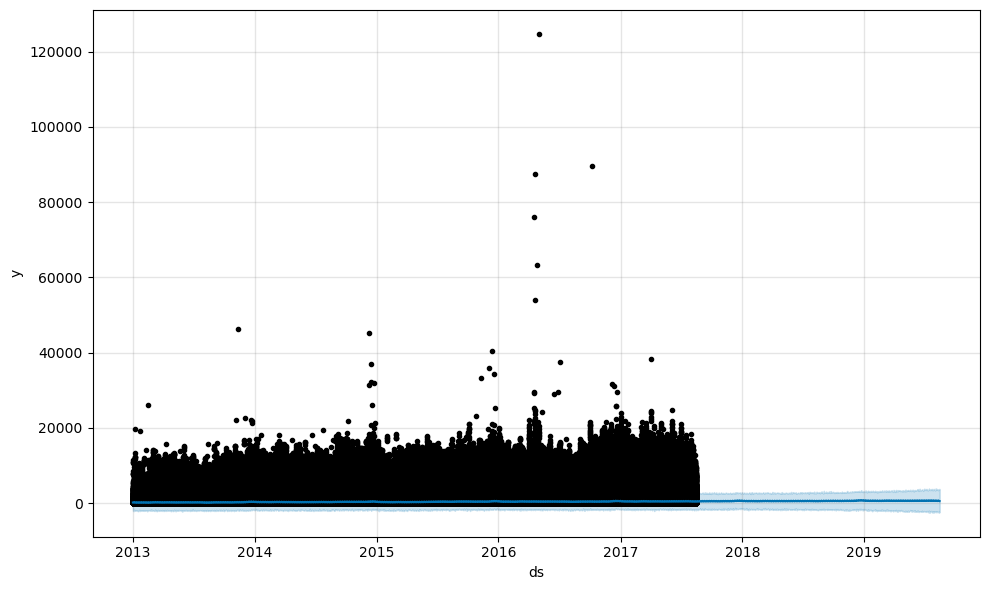

In [17]:
# Plotting the forecasted data
fig1 = model.plot(forecast)

There seems to be some outliers plotted above 40,000 on the y axis.

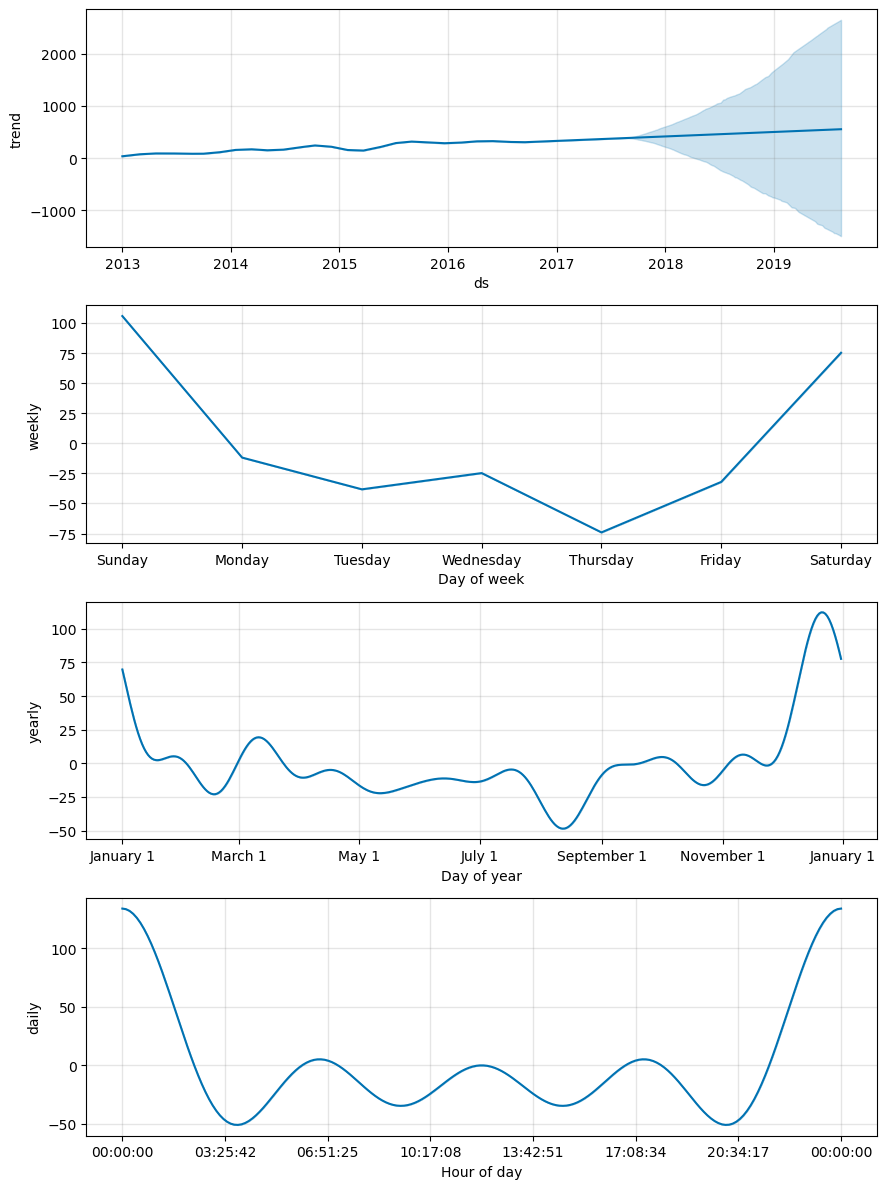

In [18]:
# Plotting components
fig2 = model.plot_components(forecast)

**Findings:**

1. From the plots above, we can see that there is minimal increment in the sales throughout 2013 to 2017. Hence, the forecasted data for the next 2 years also shows minimal increment.

2. Sales are the highest on Sundays followed by Saturdays and lowest on Thursdays.

3. Higher sales are seen to be around December, while lower sales are seen to be around September.

4. Sales normally peak during midnight (between 8.30pm to 3.30am).

**Distribution of oil_df to support the data shown for sales above**

In [19]:
#checking for the data
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [20]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [21]:
#Since there are some null values for "dcoilwtico", we'll replace it with the mean value.
oil_df['dcoilwtico'].fillna(oil_df['dcoilwtico'].mean(), inplace=True)
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1218 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [22]:
# Converting 'date' from object into datetime format
oil_df['date'] = pd.to_datetime(oil_df['date'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

#Split the date into year, month, date
oil_df['Year'] = oil_df['date'].apply(lambda x: str(x)[:4])
oil_df['Month'] = oil_df['date'].apply(lambda x: str(x)[5:7])
oil_df['Day'] = oil_df['date'].apply(lambda x: str(x)[8:10])

In [23]:
oil_df_dist= oil_df[['Month','dcoilwtico']]
oil_df_dist.head()

,Month,dcoilwtico
0,01,67.714366
1,01,93.140000
2,01,92.970000
3,01,93.120000
4,01,93.200000


In [24]:
# Calculate the average price for each month
average_prices = oil_df_dist.groupby('Month')['dcoilwtico'].mean().reset_index()

# Rename the 'price' column to 'Average_Price'
average_prices.rename(columns={'dcoilwtico': 'Average_Price'}, inplace=True)

# Print the resulting DataFrame
print(average_prices)


   Month  Average_Price
0     01      65.319222
1     02      65.826058
2     03      64.761443
3     04      68.603580
4     05      70.236413
5     06      70.277850
6     07      71.052488
7     08      67.323545
8     09      71.931005
9     10      70.963034
10    11      64.236756
11    12      61.498972


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


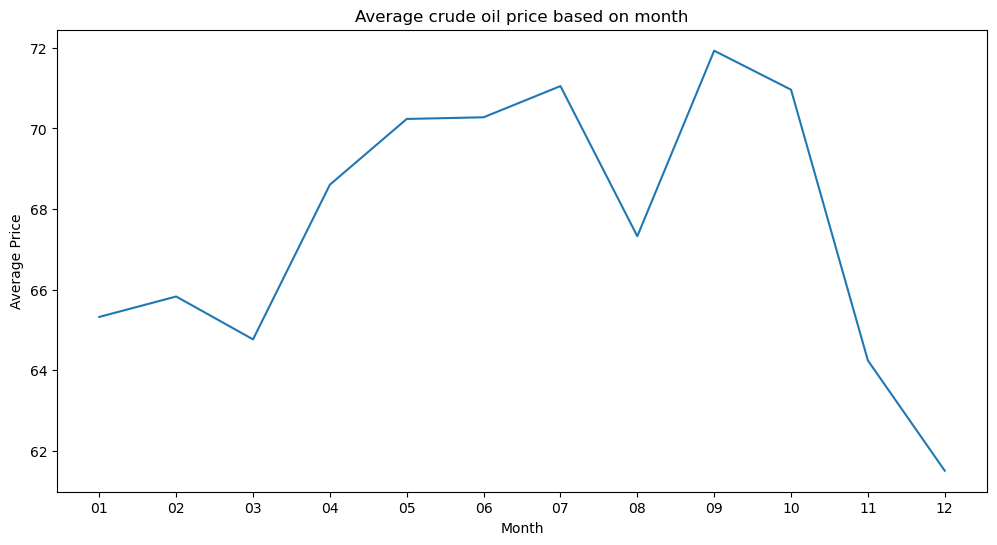

In [25]:
#plot the distribution in line graph
plt.figure(figsize=(12, 6))
plt.plot(average_prices['Month'], average_prices['Average_Price'])
plt.title('Average crude oil price based on month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.show()

**Findings**

Findings from the train file - Higher sales are seen to be around December, while lower sales are seen to be around September.
    
In this case, we can say that crude oil prices has a negative effect on the sales. For example, the sales is the lowest in September as the crude oil price is the highest in September; while the sales is the highest in December due to December being the month with lowest crude oil price.